## ⚡ Electricity Demand Forecasting | Time Series Project

### 📌 Business Context
A leading electricity distribution company aims to forecast electricity demand for the next 1–2 years to optimize production planning and vendor management. Accurate demand estimation is critical to ensure a balance between procurement and production, avoiding shortages or excess supply.

### 📅 Available Data
Duration: January 1973 – December 2019

Frequency: Monthly

Features:

Date – Month & Year

Electricity Consumption – in Trillion Watts

### 🎯 Business Objective
🔮 Forecast monthly electricity demand for the next 24 months

📊 Evaluate performance using error metrics:

RMSE (Root Mean Squared Error)

RMSPE (Root Mean Squared Percentage Error)

MAPE (Mean Absolute Percentage Error)

### ⚙️ Model Comparison:

Classical Decomposition

ETS (Exponential Smoothing) Models

ARIMA & SARIMA Models with various parameter tuning

### Importing libraries

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings("ignore")

### Loading Files

In [2]:
df = pd.read_csv(r"C:\Users\91981\OneDrive\Desktop\AL_Module3\ML_Project3\Electricity Consumption.csv")

In [3]:
df.head(3)

,DATE,Electricty_Consumption_in_TW
0,1/1/1973,35.9728
1,2/1/1973,36.1334
2,3/1/1973,35.0625


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   DATE                          561 non-null    object 
 1   Electricty_Consumption_in_TW  561 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.9+ KB


In [5]:
# Removing any non-word characters (anything not a letter, digit, or underscore)
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace(r'[^\w]', '', regex=True)

In [6]:
dt_df = pd.date_range(start= '1/1/1973' , end = '9/1/2019',freq='MS' )
dt_df = pd.DataFrame(dt_df,columns=['date'])
dt_df.head()

,date
0,1973-01-01
1,1973-02-01
2,1973-03-01
3,1973-04-01
4,1973-05-01


In [7]:
df['date'] = df['date'].apply(lambda x: pd.to_datetime(x).strftime('%Y-%m-%d'))
df.head()

,date,electricty_consumption_in_tw
0,1973-01-01,35.9728
1,1973-02-01,36.1334
2,1973-03-01,35.0625
3,1973-04-01,33.8416
4,1973-05-01,33.5107


In [8]:
df['date'] =  pd.to_datetime(df['date'])

In [9]:
df_all = dt_df.merge(df ,on = 'date',how = 'left')
df_all.set_index('date', inplace=True)
# Changing column names 
df_all.columns = ['y']

### Data Visualization & Decomposition

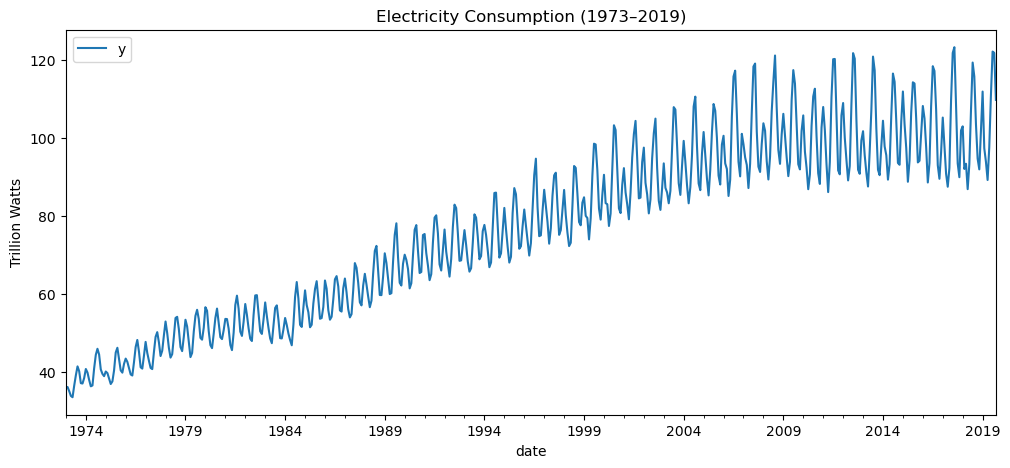

In [10]:
df_all.plot(title='Electricity Consumption (1973–2019)', figsize=(12, 5), ylabel='Trillion Watts')
plt.show()

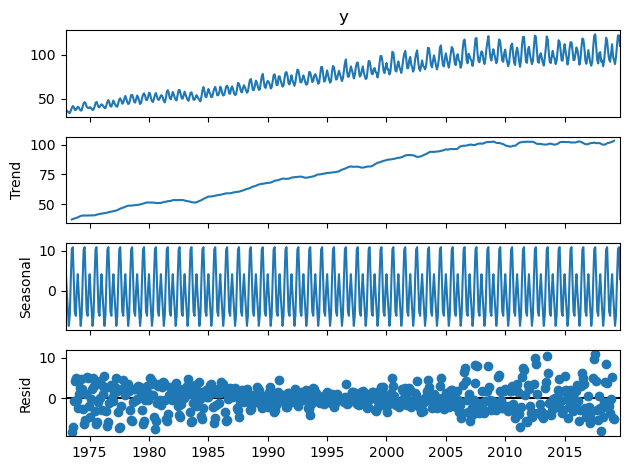

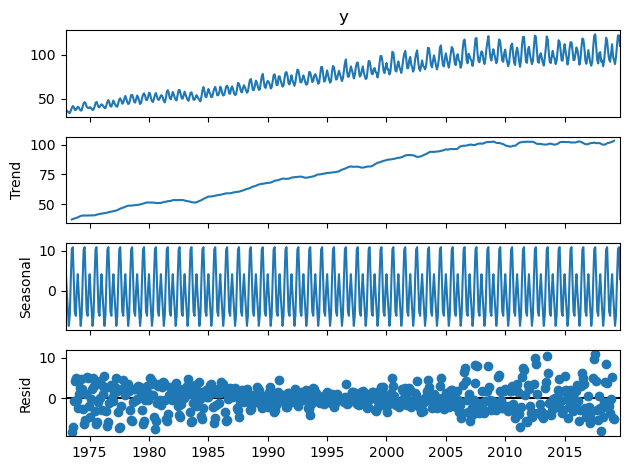

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df_all['y'], model='additive')  # You can try model='multiplicative' as well
decompose.plot()

In [12]:
df_all.isnull().sum() # There are No null values in the New Data Frame.

y    0
dtype: int64

####

### Train Test Split

In [13]:
train = df_all.iloc[:449]
test = df_all.iloc[449:]
train.shape , test.shape

((449, 1), (112, 1))

##

### Model Training

#### Exponential Smoothing 

In [14]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [15]:
es = ExponentialSmoothing(train['y'],trend='add',seasonal='add',seasonal_periods=12)
fit = es.fit()

C:\Users\91981\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [16]:
ets_forecast = fit.forecast(len(test))

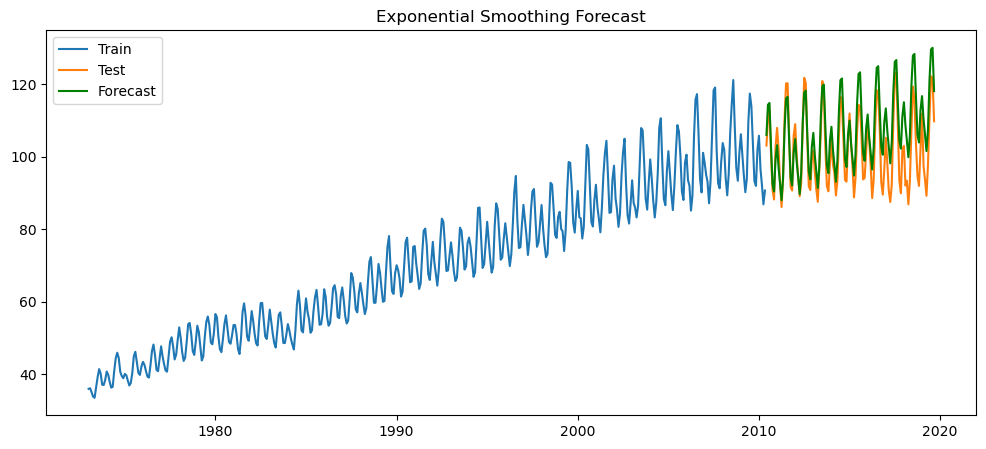

In [17]:
plt.figure(figsize=(12, 5))
plt.plot(train['y'], label='Train')
plt.plot(test['y'],label = 'Test')
plt.plot(ets_forecast,label='Forecast', color='green')
plt.title('Exponential Smoothing Forecast')
plt.legend()
plt.show()

#### SARIMA

In [18]:
from statsmodels.tsa.statespace.sarimax  import SARIMAX

In [19]:
smm = SARIMAX(train['y'],
              order=(1,1,1),
              seasonal_order=(1,1,1,12))
smm_fit = smm.fit()
smm_forecast = smm_fit.predict(start = test.index[0],end = test.index[-1])

C:\Users\91981\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\91981\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


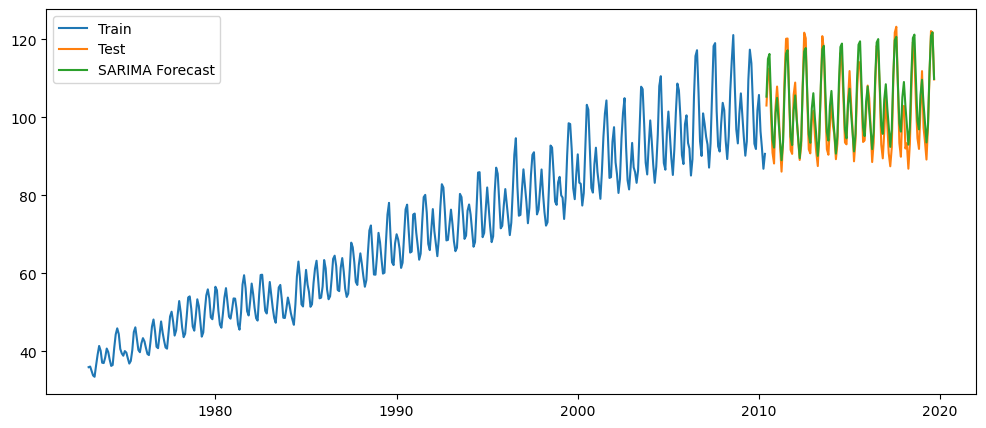

In [20]:
plt.figure(figsize=(12,5))
plt.plot(train['y'], label='Train')
plt.plot(test['y'], label='Test')
plt.plot(smm_forecast, label='SARIMA Forecast')
plt.legend()
plt.show()

### Model Evaluation 

In [21]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [22]:
def metrics_evaluate(true,predict):
    mae = mean_absolute_error(true,predict)
    rmse = np.sqrt(mean_squared_error(true,predict))
    rmspe = np.sqrt(np.mean(np.square((true - predict)/true)))*100
    mape = np.mean(np.abs((true-predict)/true))*100
    return {'MAE' : mae , 'RMSE': rmse ,'RMSPE' : rmspe , 'MAPE': mape}

ets_metrics = metrics_evaluate(test['y'],ets_forecast)
srm_metrics = metrics_evaluate(test['y'],smm_forecast)


In [23]:
print('ETS',ets_metrics)

ETS {'MAE': 6.019238451219534, 'RMSE': np.float64(7.143525678605376), 'RMSPE': np.float64(7.266696900427042), 'MAPE': np.float64(6.023071970644897)}


In [24]:
print('SARIMAX',srm_metrics)

SARIMAX {'MAE': 3.071049145385929, 'RMSE': np.float64(3.6104657849909514), 'RMSPE': np.float64(3.6954629236252443), 'MAPE': np.float64(3.091813082297742)}


##

### FINAL MODEL FORECAST [2020 - 2021]

#### Based on model evaluation, SARIMA emerged as the best-performing model for forecasting electricity consumption. It effectively captured both trend and seasonal patterns, delivering the lowest error metrics (RMSE, MAPE, RMSPE) compared to ETS and decomposition-based models. Additionally, residual diagnostics showed no significant autocorrelation, confirming a strong model fit.

In [25]:
final_model = SARIMAX(df['electricty_consumption_in_tw'],order = (1,1,1) , seasonal_order=(1,1,1,12))
final_fit = final_model.fit()
forecast = final_fit.get_forecast(steps = 24)
forecast_df = forecast.predicted_mean

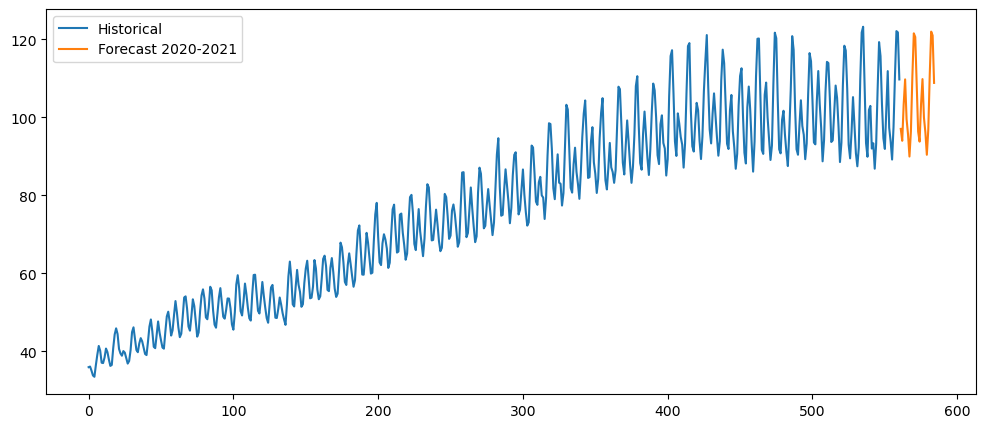

In [26]:
plt.figure(figsize=(12,5))
plt.plot(df['electricty_consumption_in_tw'], label='Historical')
plt.plot(forecast_df, label='Forecast 2020-2021')
plt.legend()
plt.show()

In [27]:
forecast_df.to_csv('Predictions.csv')